In [1]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [2]:
# remotes::install_github("glmmTMB/glmmTMB", subdir = "glmmTMB")


# Load Data

In [3]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2023.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2024.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2018_2024.csv" # nolint
local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_18.csv"
base_df <- read.csv(local_input_path)

print(base_df)


           date                        regiao mental_health_visits total_atd
1    2018-01-01                           sul                86601   3323595
2    2018-02-01                           sul                83997   3127761
3    2018-03-01                           sul                95073   3799601
4    2018-04-01                           sul                99755   3954977
5    2018-05-01                           sul                96343   3950949
6    2018-06-01                           sul                90526   3629643
7    2018-07-01                           sul                96069   3895748
8    2018-08-01                           sul               104619   4238054
9    2018-09-01                           sul                92901   3627309
10   2018-10-01                           sul               111666   4475717
11   2018-11-01                           sul                94086   3724671
12   2018-12-01                           sul                70911   2857177

# Imports

In [4]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c("lubridate"))
# install.packages(c(
#    # "lubridate",
#    # "ggplot2",
#    # "purrr",
#    #"glmmTMB"
# ))
library(gamlss.add)
library(gamlss)
library(glarma)
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
library(brms)
library(cmdstanr)
library(writexl)
library(glmmTMB) # For NB GLMM with autocorrelation

library(lubridate)
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


Carregando pacotes exigidos: gamlss.dist

Carregando pacotes exigidos: gamlss

Carregando pacotes exigidos: splines

Carregando pacotes exigidos: gamlss.data


Anexando pacote: 'gamlss.data'


O seguinte objeto é mascarado por 'package:datasets':

    sleep


Carregando pacotes exigidos: nlme

Carregando pacotes exigidos: parallel

 **********   GAMLSS Version 5.4-22  ********** 

For more on GAMLSS look at https://www.gamlss.com/

Type gamlssNews() to see new features/changes/bug fixes.


Carregando pacotes exigidos: mgcv

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


Anexando pacote: 'mgcv'


O seguinte objeto é mascarado por 'package:gamlss':

    lp


Carregando pacotes exigidos: nnet


Anexando pacote: 'nnet'


O seguinte objeto é mascarado por 'package:mgcv':

    multinom


Carregando pacotes exigidos: rpart


Anexando pacote: 'dplyr'


O seguinte objeto é mascarado por 'package:nlme':

    collapse


Os seguintes objetos são mascarados por 'package:stats':

  

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [6]:
fit_glmm_arma <- function(data,
                          response_var,
                          fixed_effects,
                          offset_var = NULL,
                          time_var,
                          group_var = NULL,
                          theta = 1,
                          ar_order = 1, # Ordem AR(p)
                          ma_order = 0) { # Ordem MA(q)

  require(nlme)
  require(MASS)
  require(dplyr)

  # Criar fórmula fixa
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Estrutura aleatória
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Estrutura de correlação ARMA
  if (ar_order > 0 | ma_order > 0) {
    cor_struct <- corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    cor_struct <- NULL
  }

  # Ajustar modelo
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


In [7]:
library(nlme)
library(MASS)
library(dplyr)

# 1) Função auxiliar para estimar α e θ por momentos a partir de um ajuste Poisson
estimate_theta_moments <- function(df, response_var, fixed_effects, offset_var = NULL) {
  # montar fórmula
  rhs <- paste(fixed_effects, collapse = " + ")
  if (!is.null(offset_var)) rhs <- paste0(rhs, " + offset(", offset_var, ")")
  form <- as.formula(paste(response_var, "~", rhs))

  # ajusta Poisson
  pois <- glm(form, data = df, family = poisson())

  # extrai y e mu
  y <- df[[response_var]]
  mu <- fitted(pois)

  # estimador de momentos para α: sum[(y - mu)^2 - mu] / sum(mu^2)
  num <- sum((y - mu)^2 - mu)
  den <- sum(mu^2)
  alpha_hat <- max(num / den, 0)

  # θ = 1/α (MASS::negative.binomial() usa var = μ + μ^2/θ)
  theta_hat <- if (alpha_hat > 0) 1 / alpha_hat else Inf

  # opcional: índice de dispersão Pearson φ
  pearson_chi2 <- sum((y - mu)^2 / mu)
  phi_hat <- pearson_chi2 / pois$df.residual

  list(alpha = alpha_hat, phi = phi_hat, theta = theta_hat)
}

# 2) Função principal, agora estimando θ se não for fornecido
fit_glmm_arma_2moment <- function(data,
                                  response_var,
                                  fixed_effects,
                                  offset_var = NULL,
                                  time_var,
                                  group_var = NULL,
                                  theta = NULL,
                                  ar_order = 1,
                                  ma_order = 0) {
  # estima θ via momentos se theta=NULL
  if (is.null(theta)) {
    est <- estimate_theta_moments(data, response_var, fixed_effects, offset_var)
    theta <- est$theta
    message(sprintf(
      "Estimativa de theta por momentos: %.3f (α = %.4f, φ = %.3f)",
      theta, est$alpha, est$phi
    ))
  }

  # construir parte fixa da fórmula
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))
  if (!is.null(offset_var)) {
    fixed_part <- paste0(fixed_part, " + offset(", offset_var, ")")
  }

  # estrutura de efeitos aleatórios e correlação
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # correlação ARMA
  cor_struct <- if (ar_order > 0 || ma_order > 0) {
    corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    NULL
  }

  # ajuste final
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


# Model Run

In [ ]:
# Inicialize uma lista para guardar os modelos
models_list <- list()


start_y <- 2016
end_y <- 2023

# base_df <- base_df %>% mutate(date = as.Date(date))
# regression_df <- base_df %>%
#  filter(between((year(date)), start_y, end_y))

regression_df <- base_df
sink("final_model_summaries.txt", append = FALSE)

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma_2moment(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend",
      "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )



  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model

  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação

  # print(summary(model))


  summary_text <- capture.output(summary(model))
  cat(paste0("Resumo para ", reg, ":\n"))
  cat(summary_text, sep = "\n")
  cat("\n\n")
}
sink()


Estimativa de theta por momentos: 331.331 (α = 0.0030, φ = 460.916)

Estimativa de theta por momentos: 461.861 (α = 0.0022, φ = 648.063)

Estimativa de theta por momentos: 257.436 (α = 0.0039, φ = 114.768)

Estimativa de theta por momentos: 356.322 (α = 0.0028, φ = 400.139)

Estimativa de theta por momentos: 213.928 (α = 0.0047, φ = 231.302)

Estimativa de theta por momentos: 181.639 (α = 0.0055, φ = 80.524)

Estimativa de theta por momentos: 246.323 (α = 0.0041, φ = 127.674)

Estimativa de theta por momentos: 198.500 (α = 0.0050, φ = 292.819)

Estimativa de theta por momentos: 276.443 (α = 0.0036, φ = 50.199)

Estimativa de theta por momentos: 384.986 (α = 0.0026, φ = 15.005)

Estimativa de theta por momentos: 537.383 (α = 0.0019, φ = 38.186)

Estimativa de theta por momentos: 397.490 (α = 0.0025, φ = 770.689)

Estimativa de theta por momentos: 427.045 (α = 0.0023, φ = 385.230)

Estimativa de theta por momentos: 412.963 (α = 0.0024, φ = 107.438)

Estimativa de theta por momentos: 375.

# Diagnóstico

In [9]:
# GLMM TMB
if (!dir.exists("acf_plots")) dir.create("acf_plots")
if (!dir.exists("model_tests")) dir.create("model_tests")

sink(file = "model_tests/ljung_box_results.txt")

for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Resíduos de Pearson
  res <- residuals(model, type = "pearson")

  # Plot ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  acf(res, main = paste("ACF -", reg), lag.max = 36, ylim = c(-0.5, 1))
  pacf(res, main = paste("PACF -", reg), lag.max = 36, ylim = c(-0.5, 1))

  dev.off()

  # Teste Ljung-Box
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos de Pearson:\n\n")

  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  cat("Gráficos e testes gerados para:", reg, "\n")
}

sink()


In [10]:
# Criar pastas para salvar os resultados
if (!dir.exists("acf_plots")) {
  dir.create("acf_plots")
}
if (!dir.exists("model_tests")) {
  dir.create("model_tests")
}

# Arquivo para salvar os testes Ljung-Box
sink(file = "model_tests/ljung_box_results.txt")

# Loop através de cada modelo na lista
for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Extrair resíduos normalizados
  res <- residuals(model, type = "normalized")

  # Gráficos ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  # Plot ACF
  acf(res,
    main = paste("ACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  # Plot PACF
  pacf(res,
    main = paste("PACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  dev.off()

  # Teste Ljung-Box para diferentes lags
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos:\n\n")

  # Testar para lags específicos (1, 9, 12, 24, 25)
  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))

    # Adicionar asterisco para significância
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  # Mostrar mensagem de progresso
  cat("Gráficos e testes gerados para:", reg, "\n")
}

# Fechar o arquivo de saída
sink()


# Extrair

In [11]:
extrair_tabela_formatada <- function(models_list,
                                     coef_map = NULL,
                                     round_digits = 3) {
  if (is.null(coef_map)) {
    coef_map <- list(
      "Pandemia_Step" = c("Pandemia", "Mudança de nível"),
      "Pandemia_Trend" = c("Pandemia", "Mudança de tendência"),
      "PosPandemia_Step" = c("Pós-pandemia", "Mudança de nível"),
      "PosPandemia_Trend" = c("Pós-pandemia", "Mudança de tendência")
    )
  }

  linhas <- list()

  for (regiao in names(models_list)) {
    model <- models_list[[regiao]]
    coefs <- summary(model)$tTable

    for (coef in names(coef_map)) {
      if (coef %in% rownames(coefs)) {
        beta <- coefs[coef, "Value"]
        se <- coefs[coef, "Std.Error"]
        pval <- coefs[coef, "p-value"]

        irr <- exp(beta)
        ci_low <- exp(beta - 1.96 * se)
        ci_high <- exp(beta + 1.96 * se)

        p_str <- ifelse(pval < 0.001, "< 0.001", round(pval, 4))

        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = round(irr, round_digits),
          IC95 = sprintf("%.*f – %.*f", round_digits, ci_low, round_digits, ci_high),
          p_valor = p_str,
          stringsAsFactors = FALSE
        )
      } else {
        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = "",
          IC95 = "",
          p_valor = "",
          stringsAsFactors = FALSE
        )
      }

      linhas[[length(linhas) + 1]] <- linha
    }
  }

  df <- do.call(rbind, linhas)

  # Pivotar para formato mais legível com colunas por período
  library(tidyr)
  df_pivot <- df %>%
    pivot_wider(
      names_from = Periodo,
      values_from = c(IRR, IC95, p_valor),
      names_sep = "_"
    )

  return(df_pivot)
}


In [12]:
extrair_tabela_formatada_wide <- function(models_list,
                                          coef_map = NULL,
                                          round_digits = 5) {
  if (is.null(coef_map)) {
    coef_map <- list(
      "periodo" = c("Pré-pandemia", "Tendência"),
      "Pandemia_Step" = c("Pandemia", "Mudança de nível"),
      "Pandemia_Trend" = c("Pandemia", "Mudança de tendência"),
      "PosPandemia_Step" = c("Pós-pandemia", "Mudança de nível"),
      "PosPandemia_Trend" = c("Pós-pandemia", "Mudança de tendência")
    )
  }

  linhas <- list()

  for (regiao in names(models_list)) {
    model <- models_list[[regiao]]
    coefs <- summary(model)$tTable
    linha <- list(Regiao = regiao)

    for (coef in names(coef_map)) {
      if (coef %in% rownames(coefs)) {
        beta <- coefs[coef, "Value"]
        se <- coefs[coef, "Std.Error"]
        pval <- coefs[coef, "p-value"]

        irr <- exp(beta)
        ci_low <- exp(beta - 1.96 * se)
        ci_high <- exp(beta + 1.96 * se)

        p_str <- ifelse(pval < 0.001, "< 0.001", round(pval, 4))

        linha[[paste0("IRR_", coef)]] <- round(irr, round_digits)
        linha[[paste0("IC95_", coef)]] <- sprintf("%.*f – %.*f", round_digits, ci_low, round_digits, ci_high)
        linha[[paste0("p_", coef)]] <- p_str
      } else {
        linha[[paste0("IRR_", coef)]] <- ""
        linha[[paste0("IC95_", coef)]] <- ""
        linha[[paste0("p_", coef)]] <- ""
      }
    }

    linhas[[length(linhas) + 1]] <- as.data.frame(linha, stringsAsFactors = FALSE)
  }

  df_final <- do.call(rbind, linhas)
  return(df_final)
}


In [13]:
extrair_resultados_its_glmmpql <- function(models_list,
                                           coef_names = c("Intercept", "periodo", "Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend"),
                                           add_exp = TRUE,
                                           round_digits = 6,
                                           formato = c("wide", "long")) {
  formato <- match.arg(formato)
  resultados <- list()

  for (regiao in names(models_list)) {
    modelo <- models_list[[regiao]]
    coefs <- summary(modelo)$tTable

    if (formato == "long") {
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha <- data.frame(
            Regiao_Grupo = regiao,
            Coeficiente = coef,
            beta = round(beta, round_digits),
            se = round(se, round_digits),
            p = round(pval, 4),
            CI95_inf = round(ci_low, round_digits),
            CI95_sup = round(ci_high, round_digits),
            stringsAsFactors = FALSE
          )

          if (add_exp) {
            linha$exp_beta <- round(exp(beta), round_digits)
            linha$exp_CI95_inf <- round(exp(ci_low), round_digits)
            linha$exp_CI95_sup <- round(exp(ci_high), round_digits)
          }

          resultados[[length(resultados) + 1]] <- linha
        }
      }
    } else if (formato == "wide") {
      linha <- list(Regiao_Grupo = regiao)
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha[[paste0(coef, "_coef")]] <- round(beta, round_digits)
          linha[[paste0(coef, "_se")]] <- round(se, round_digits)
          linha[[paste0(coef, "_p")]] <- round(pval, 4)
          linha[[paste0(coef, "_ci95_inf")]] <- round(ci_low, round_digits)
          linha[[paste0(coef, "_ci95_sup")]] <- round(ci_high, round_digits)

          if (add_exp) {
            linha[[paste0(coef, "_exp")]] <- round(exp(beta), round_digits)
            linha[[paste0(coef, "_exp_ci95_inf")]] <- round(exp(ci_low), round_digits)
            linha[[paste0(coef, "_exp_ci95_sup")]] <- round(exp(ci_high), round_digits)
          }
        }
      }
      resultados[[length(resultados) + 1]] <- as.data.frame(linha, stringsAsFactors = FALSE)
    }
  }

  df_resultados <- do.call(rbind, resultados)
  return(df_resultados)
}


In [14]:
# tabela_resultados <- extrair_tabela_formatada(models_list)
tabela_resultados <- extrair_tabela_formatada_wide(models_list)
print(tabela_resultados)



coefs <- extrair_resultados_its_glmmpql(models_list, formato = "wide")

writexl::write_xlsx(coefs, "coefs_glmmpql.xlsx")
writexl::write_xlsx(tabela_resultados, "resultados_modelos_glmmpql.xlsx")


                          Regiao IRR_periodo      IC95_periodo p_periodo
1                            sul     1.00480 1.00121 – 1.00840    0.0109
2                        sudeste     1.01321 1.00981 – 1.01662   < 0.001
3                          norte     1.00869 1.00276 – 1.01465    0.0054
4                       nordeste     1.01569 1.01120 – 1.02019   < 0.001
5                   centro_oeste     1.00767 1.00307 – 1.01229    0.0017
6       F99_F99_nao_especificado     1.02427 1.01635 – 1.03225   < 0.001
7          F90_F98_comportamento     1.00209 0.99754 – 1.00667     0.371
8        F80_F89_desenvolvimento     1.01565 1.00706 – 1.02431   < 0.001
9              F70_F79_retardado     1.00737 1.00329 – 1.01147   < 0.001
10         F60_F69_personalidade     1.02124 1.01758 – 1.02490   < 0.001
11          F50_F59_fisiologicos     1.01096 1.00807 – 1.01386   < 0.001
12              F40_F48_ansiosos     1.01445 1.01069 – 1.01823   < 0.001
13                 F30_F39_humor     1.00800 1.0043

# Def plot panel

In [15]:
library(ggplot2)
library(dplyr)
library(purrr)

# Junta os dados com as previsões em um único data.frame
all_data <- map_dfr(names(models_list), function(reg) {
  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      regiao = reg, # garante que a coluna regiao esteja presente
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  return(reg_data)
})


In [16]:
# Define as regiões que vão para o primeiro painel
regioes_principais <- c("Brasil", "centro_oeste", "nordeste", "norte", "sudeste", "sul")
neuroticos <- c("F30_F39", "F40_F48")
brasil__ <- c("Brasil")


# Adiciona a variável 'painel'
panel_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% regioes_principais,
      "Brasil e macrorregiões",
      "Agrupamentos de Transtornos Mentais"
    )
  )

neuroticos_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% neuroticos,
      "Humor e Ansiedade",
      "outros"
    )
  )

brasil_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% brasil__,
      "Brasil",
      "outros"
    )
  )


painel_1 <- panel_data %>% filter(painel == "Brasil e macrorregiões")
painel_neuroticos <- neuroticos_data %>% filter(painel == "Humor e Ansiedade")
painel_2 <- panel_data %>% filter(painel == "Agrupamentos de Transtornos Mentais")
painel_brasil <- brasil_data %>% filter(painel == "Brasil")


# Def Plot func


In [17]:
plot_its_painel <- function(data,
                            titulo = "ITS por região",
                            ncol = 3,
                            scales = "free_y",
                            pandemic_start = 28,
                            post_start = 52) {
  # Definir variáveis
  data$volume_abs <- data$mental_health_visits
  # Calcular fatores de escala
  max_taxa <- max(data$predicted_segmented, na.rm = TRUE)
  max_vol <- max(data$volume_abs, na.rm = TRUE)
  vol_to_taxa <- max_taxa / max_vol

  ggplot(data, aes(x = periodo)) +
    # Barras de volume absoluto escaladas para o eixo taxa
    geom_col(aes(y = volume_abs * vol_to_taxa),
      fill = "lightgray",
      alpha = 0.6,
      position = "identity"
    ) +

    # Pontos observados de taxa
    geom_point(aes(y = IR), size = 0.75, alpha = 0.6) +

    # Linha segmentada para taxa
    geom_line(aes(y = predicted_segmented, group = fase),
      color = "#8c00ff", size = 0.8
    ) +

    # Linha contrafactual contínua
    geom_line(aes(y = predicted_counterfactual),
      linetype = "dashed"
    ) +

    # Sombreamento de fases
    annotate("rect",
      xmin = pandemic_start, xmax = post_start,
      ymin = -Inf, ymax = Inf,
      fill = "grey90", alpha = 0.3
    ) +
    annotate("rect",
      xmin = post_start, xmax = Inf,
      ymin = -Inf, ymax = Inf,
      fill = "grey80", alpha = 0.3
    ) +

    # Linhas verticais de corte
    geom_vline(
      xintercept = c(pandemic_start, post_start),
      linetype = "dotted"
    ) +

    # Eixos primário (taxa) e secundário (volume)
    scale_y_continuous(
      name = "Taxa por 1000 atendimentos",
      sec.axis = sec_axis(~ . / vol_to_taxa,
        name = "Volume absoluto de atendimentos"
      )
    ) +
    facet_wrap(~regiao, scales = scales, ncol = ncol) +
    labs(
      title = titulo,
      x = "Período (mês)"
    ) +
    theme_minimal() +
    theme(
      strip.text = element_text(face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}


In [18]:
library(ggplot2)
library(dplyr)

plot_its_semi_free <- function(data,
                               titulo = "ITS por região (escala semi‑livre)",
                               pandemic_start = 28,
                               post_start = 52) {
  # 1) Classifica cada série em "Alta" ou "Baixa" magnitude
  data2 <- data %>%
    mutate(
      grupo_magnitude = case_when(
        regiao %in% c("F30_F39_humor", "F40_F48_ansiosos") ~ "Alta",
        TRUE ~ "Baixa"
      )
    )

  # 2) Calcula o fator de escala (igual ao anterior)
  data2 <- data2 %>%
    mutate(volume_abs = mental_health_visits)
  max_taxa <- max(data2$predicted_segmented, na.rm = TRUE)
  max_vol <- max(data2$volume_abs, na.rm = TRUE)
  vol_to_taxa <- max_taxa / max_vol

  # 3) Plota com duas linhas de facetas e scales="free_y"
  ggplot(data2, aes(x = periodo)) +
    geom_col(aes(y = volume_abs * vol_to_taxa),
      fill = "lightgray", alpha = 0.6
    ) +
    geom_point(aes(y = IR), size = 0.6, alpha = 0.6) +
    geom_line(aes(y = predicted_segmented, group = fase),
      color = "#8c00ff", size = 0.8
    ) +
    geom_line(aes(y = predicted_counterfactual),
      linetype = "dashed"
    ) +
    annotate("rect",
      xmin = pandemic_start, xmax = post_start,
      ymin = -Inf, ymax = Inf, fill = "grey90", alpha = 0.3
    ) +
    annotate("rect",
      xmin = post_start, xmax = Inf,
      ymin = -Inf, ymax = Inf, fill = "grey80", alpha = 0.3
    ) +
    geom_vline(
      xintercept = c(pandemic_start, post_start),
      linetype = "dotted"
    ) +
    scale_y_continuous(
      name = "Taxa por 1.000 atendimentos",
      sec.axis = sec_axis(~ . / vol_to_taxa,
        name = "Volume absoluto"
      )
    ) +
    facet_grid(
      rows = vars(grupo_magnitude),
      cols = vars(regiao),
      scales = "free_y",
      drop = TRUE,
    ) +
    labs(title = titulo, x = "Período (mês)") +
    theme_minimal(base_size = 12) +
    theme(
      strip.text        = element_text(face = "bold"),
      axis.text.x       = element_text(angle = 45, hjust = 1),
      panel.spacing.x   = unit(0.5, "lines"),
      panel.spacing.y   = unit(1, "lines")
    )
}


In [19]:
library(ggplot2)
library(dplyr)
library(patchwork)

start_year <- 2018

# Função de base de plotagem (sem facet_wrap)
base_plot <- function(df, base_size = 12) {
  max_taxa <- max(df$predicted_segmented, na.rm = TRUE)
  max_vol <- max(df$mental_health_visits, na.rm = TRUE)
  vol_to_taxa <- max_taxa / max_vol

  lower_period <- min(df$periodo, na.rm = TRUE)
  upper_period <- max(df$periodo, na.rm = TRUE)

  pandemic_index <- (2020 - start_year) * 12 + 4
  post_index <- (2022 - start_year) * 12 + 4

  ggplot(df, aes(x = periodo)) +
    geom_col(aes(y = mental_health_visits * vol_to_taxa),
      fill = "lightgray", alpha = 0.6
    ) +
    geom_point(aes(y = IR), size = 0.7, alpha = 0.6) +
    geom_line(aes(y = predicted_segmented, group = fase),
      color = "#8c00ff", size = 0.8
    ) +
    geom_line(aes(y = predicted_counterfactual),
      linetype = "dashed", size = 0.8, alpha = 0.7
    ) +
    annotate("rect",
      xmin = pandemic_index, xmax = Inf,
      ymin = -Inf, ymax = Inf,
      fill = "grey90", alpha = 0.4
    ) +
    annotate("rect",
      xmin = post_index, xmax = Inf,
      ymin = -Inf, ymax = Inf,
      fill = "grey80", alpha = 0.4
    ) +
    geom_vline(
      xintercept = c(pandemic_index, post_index),
      linetype = "dotted"
    ) +
    scale_y_continuous(
      name = "Taxa por 1.000 atendimentos",
      sec.axis = sec_axis(~ . / vol_to_taxa,
        name = "Volume absoluto"
      )
    ) +
    scale_x_continuous(
      name = "Ano",
      breaks = seq(lower_period, upper_period, by = 12),
      labels = function(x) {
        start_year + (x - lower_period) %/% 12
      }
    ) +
    # scale_x_continuous(
    #  name = "Período (mês)",
    #  breaks = seq(min(df$periodo, na.rm = TRUE), max(df$periodo, na.rm = TRUE), by = 12)
    # )+
    theme_minimal(base_size = base_size) +
    theme(
      strip.text.x = element_text(face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}



Anexando pacote: 'patchwork'


O seguinte objeto é mascarado por 'package:MASS':

    area




Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


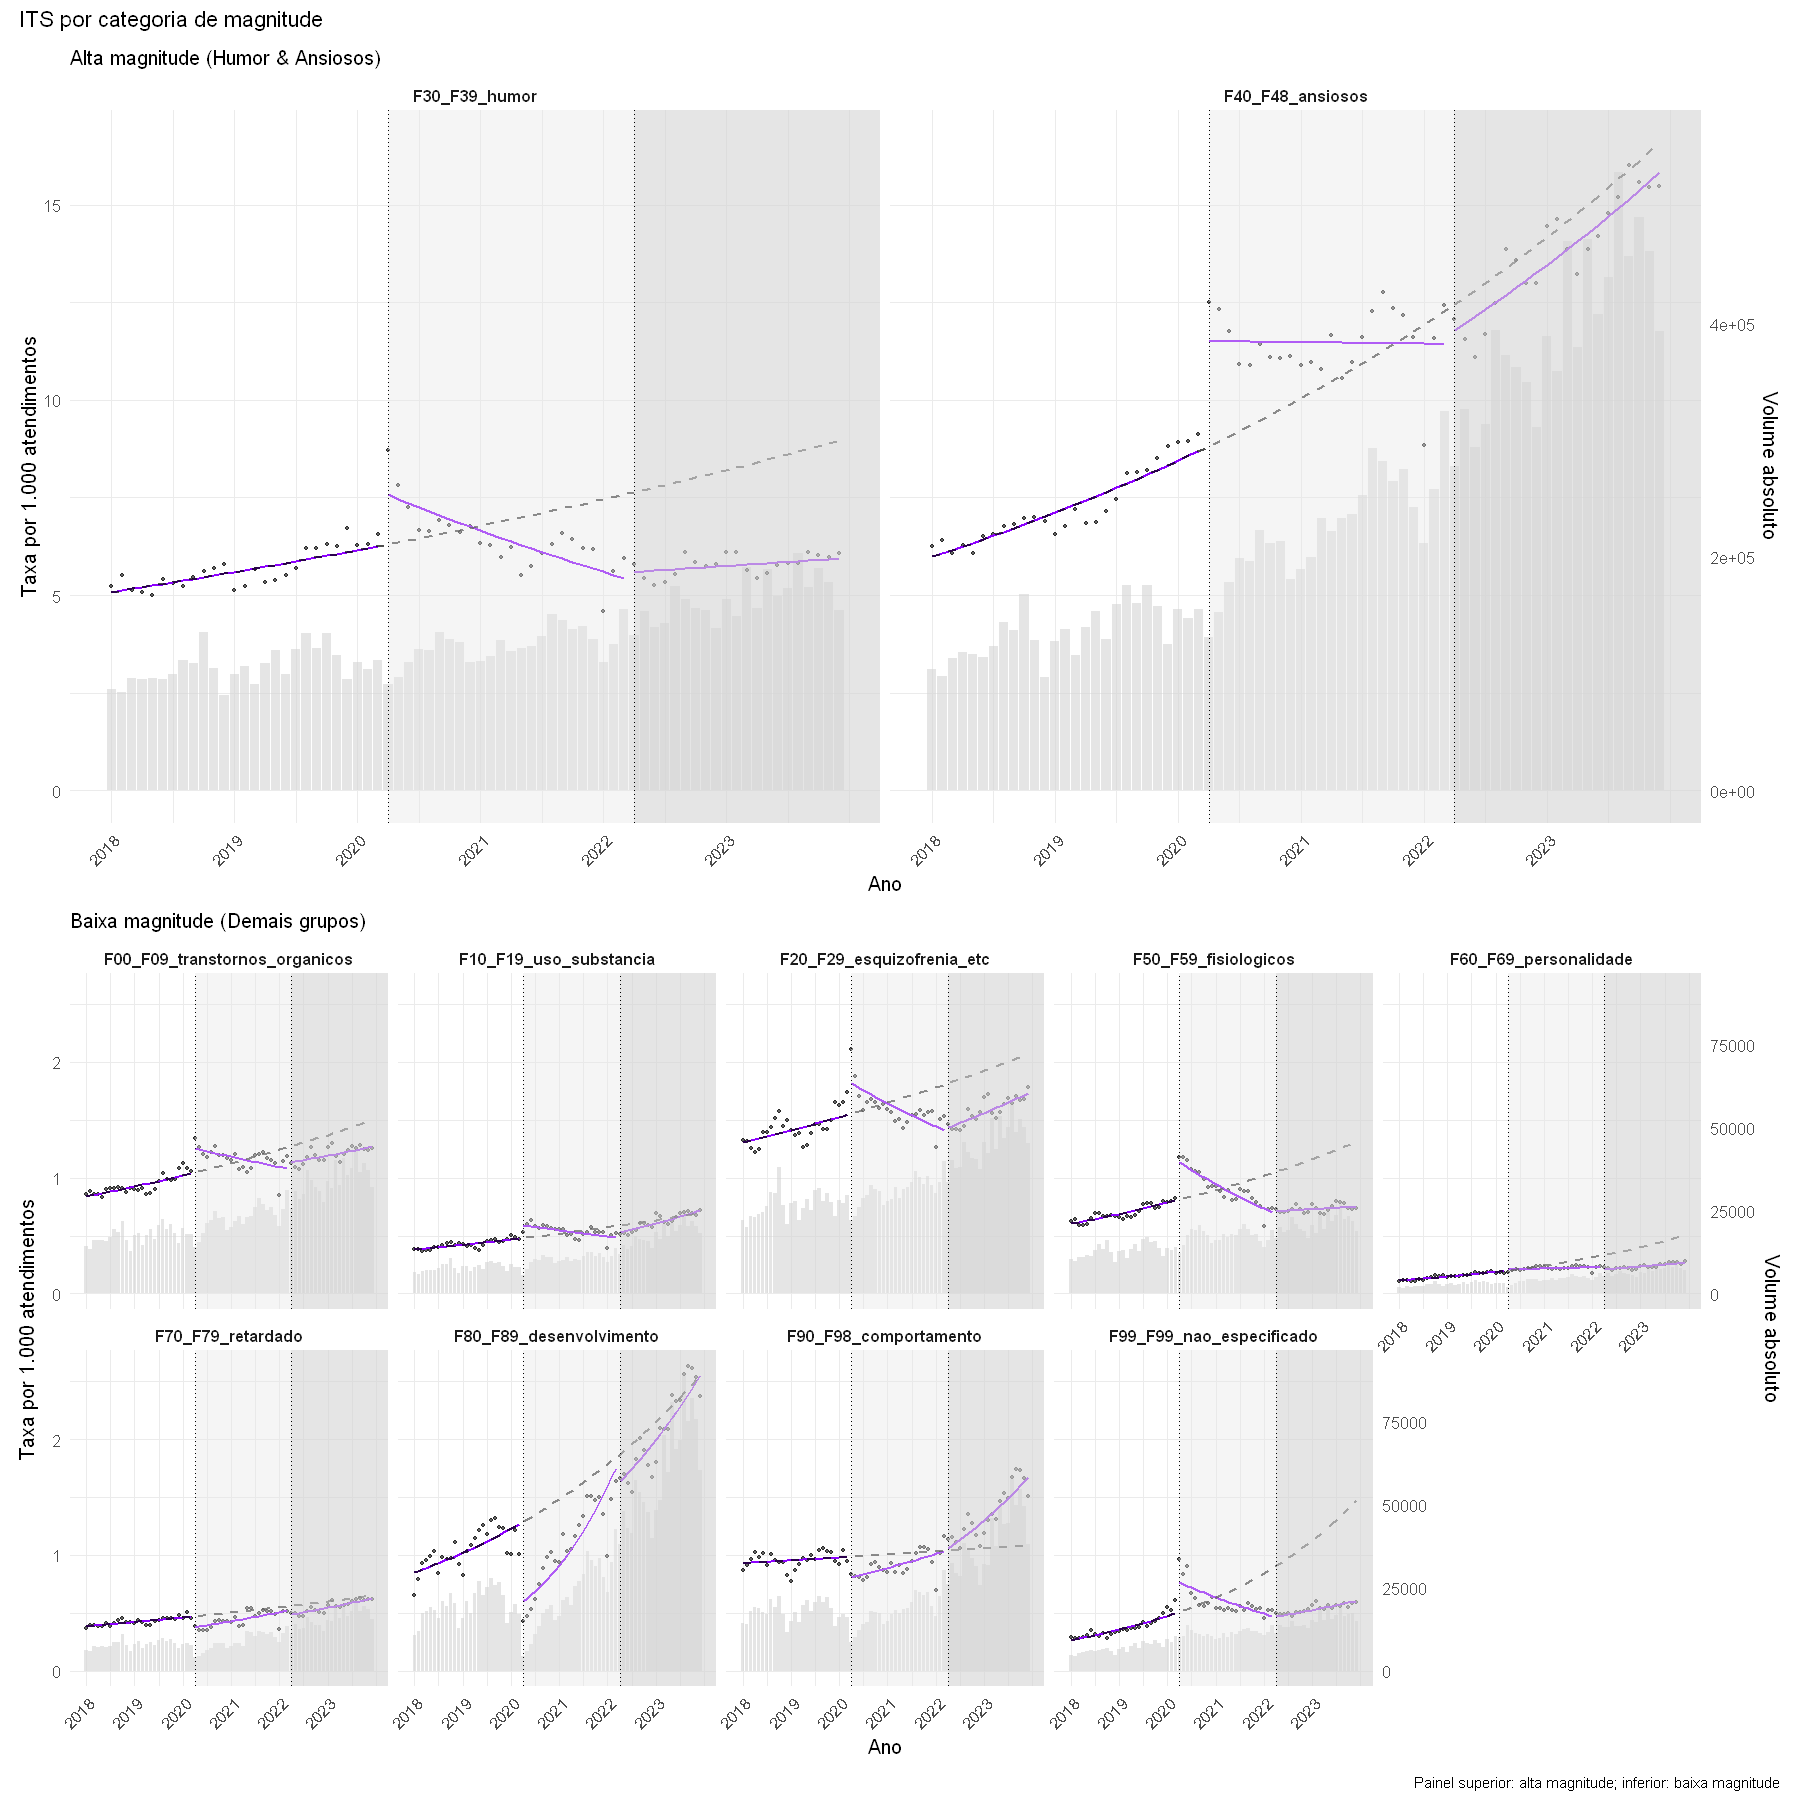

In [20]:
# Plot para Alta magnitude (2 regiões, 2 linhas)
p_alta <- all_data %>%
  filter(regiao %in% c("F30_F39_humor", "F40_F48_ansiosos")) %>%
  base_plot() +
  facet_wrap(~regiao, nrow = 1, ncol = 3, scales = "fixed", drop = FALSE) +

  labs(subtitle = "Alta magnitude (Humor & Ansiosos)")

# Plot para Baixa magnitude (restantes 8, distribuídos em 2 linhas)
p_baixa <- painel_2 %>%
  filter(!regiao %in% c("F30_F39_humor", "F40_F48_ansiosos")) %>%
  base_plot() +
  facet_wrap(~regiao, nrow = 2, scales = "fixed", drop = FALSE) +
  labs(subtitle = "Baixa magnitude (Demais grupos)")

# Combina verticalmente — total de 4 linhas de faceta
options(repr.plot.width = 15, repr.plot.height = 15)
final_plot <- p_alta / p_baixa +
  plot_annotation(
    title   = "ITS por categoria de magnitude",
    caption = "Painel superior: alta magnitude; inferior: baixa magnitude"
  )

# ggsave(
#  filename = "its_semi_free.png",
#  plot     = final_plot,
#  width    = 12,    # em polegadas
#  height   = 10,    # em polegadas
#  dpi      = 300,   # resolução
#  units    = "in"   # unidade das dimensões
# )
print(final_plot)


# Tabela delta abs


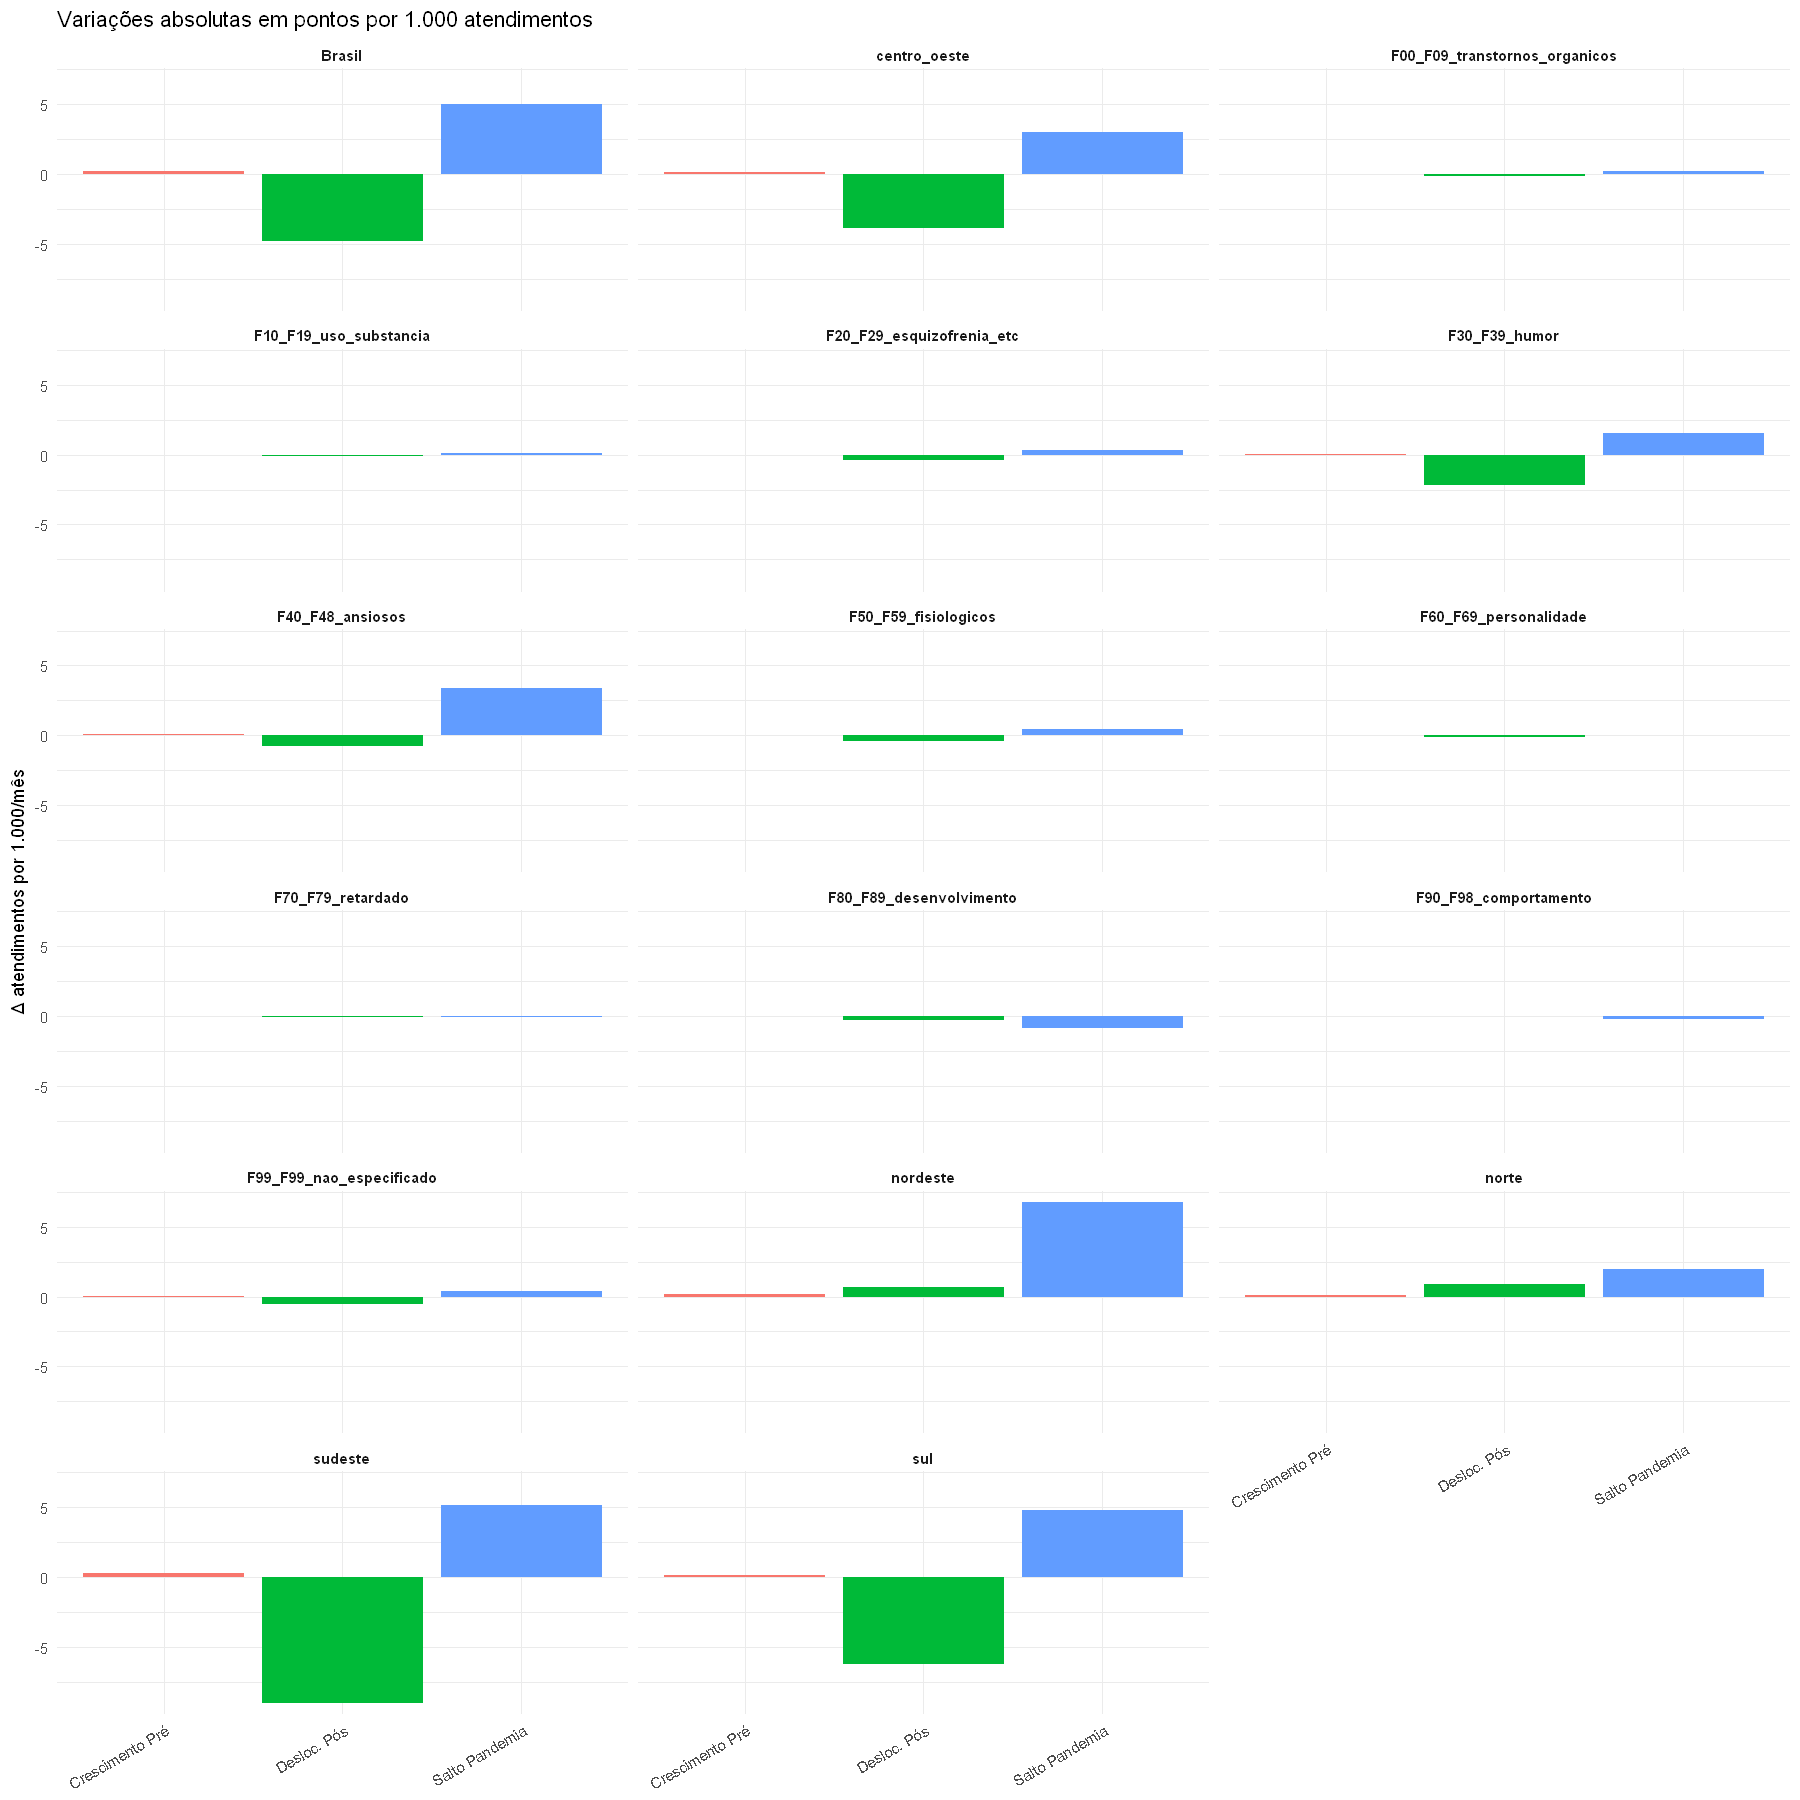

In [21]:
library(dplyr)
library(tidyr)
library(ggplot2)

# 1) Calcular IRRs diretamente a partir dos coeficientes
coef_df <- map_dfr(names(models_list), function(reg) {
  model <- models_list[[reg]]
  b <- fixef(model)
  tibble(
    grupo          = reg,
    IRR_slope_pre  = exp(b["periodo"]),
    IRR_step_pand  = exp(b["Pandemia_Step"]),
    IRR_step_post  = exp(b["PosPandemia_Step"])
  )
})

# 2) Extrair médias pré, pand e pós
levels_df <- all_data %>%
  dplyr::group_by(regiao, fase) %>%
  dplyr::summarise(
    mean_cf = mean(predicted_counterfactual, na.rm = TRUE),
    mean_seg = mean(predicted_segmented, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_wider(
    names_from  = fase,
    values_from = c(mean_cf, mean_seg),
    names_sep   = "_"
  ) %>%
  dplyr::rename(
    baseline_taxa     = mean_cf_pre,
    cf_pandemia       = mean_cf_pandemia,
    cf_pos            = mean_cf_pos,
    seg_pandemia      = mean_seg_pandemia,
    seg_pos           = mean_seg_pos
  )

# 3) Juntar e calcular deltas absolutos
summary_df <- coef_df %>%
  dplyr::left_join(levels_df, by = c("grupo" = "regiao")) %>%
  dplyr::mutate(
    delta_slope_pre = baseline_taxa * (IRR_slope_pre - 1),
    delta_step_pand = cf_pandemia * (IRR_step_pand - 1),
    delta_step_post = cf_pos * (IRR_step_post - 1)
  ) %>%
  dplyr::select(grupo, delta_slope_pre, delta_step_pand, delta_step_post)

# 4) Transformar em formato longo
df_plot <- summary_df %>%
  tidyr::pivot_longer(
    cols      = starts_with("delta_"),
    names_to  = "fase",
    values_to = "delta_abs"
  ) %>%
  dplyr::mutate(fase = recode(fase,
    delta_slope_pre = "Crescimento Pré",
    delta_step_pand = "Salto Pandemia",
    delta_step_post = "Desloc. Pós"
  ))

# 5) Gerar o painel gráfico
ggplot(df_plot, aes(x = fase, y = delta_abs, fill = fase)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~grupo, scales = "fixed", ncol = 3) +
  labs(
    title = "Variações absolutas em pontos por 1.000 atendimentos",
    x     = NULL,
    y     = "Δ atendimentos por 1.000/mês"
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(face = "bold"),
    axis.text.x = element_text(angle = 30, hjust = 1)
  )


In [22]:
# 1) Calcular IRRs diretamente a partir dos coeficientes
coef_df <- map_dfr(names(models_list), function(reg) {
  model <- models_list[[reg]]
  b <- fixef(model)
  tibble(
    grupo             = reg,
    IRR_slope_pre     = exp(b["periodo"]),
    IRR_slope_pand    = exp(b["Pandemia_Trend"]),
    IRR_slope_post    = exp(b["PosPandemia_Trend"]),
    IRR_step_pand     = exp(b["Pandemia_Step"]),
    IRR_step_post     = exp(b["PosPandemia_Step"])
  )
})


# 2) Extrair médias pré, pand e pós
levels_df <- all_data %>%
  dplyr::group_by(regiao, fase) %>%
  dplyr::summarise(
    mean_cf = mean(predicted_counterfactual, na.rm = TRUE),
    mean_seg = mean(predicted_segmented, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_wider(
    names_from  = fase,
    values_from = c(mean_cf, mean_seg),
    names_sep   = "_"
  ) %>%
  dplyr::rename(
    baseline_taxa     = mean_cf_pre,
    cf_pandemia       = mean_cf_pandemia,
    cf_pos            = mean_cf_pos,
    seg_pandemia      = mean_seg_pandemia,
    seg_pos           = mean_seg_pos
  )

# 3) Juntar e calcular deltas absolutos
summary_df <- coef_df %>%
  dplyr::left_join(levels_df, by = c("grupo" = "regiao")) %>%
  dplyr::mutate(
    delta_slope_pre  = baseline_taxa * (IRR_slope_pre - 1),
    delta_slope_pand = cf_pandemia * (IRR_slope_pand - 1),
    delta_slope_post = cf_pos * (IRR_slope_post - 1),
    delta_step_pand  = cf_pandemia * (IRR_step_pand - 1),
    delta_step_post  = cf_pos * (IRR_step_post - 1)
  ) %>%
  dplyr::select(
    grupo,
    delta_slope_pre,
    delta_slope_pand,
    delta_slope_post,
    delta_step_pand,
    delta_step_post
  )

# summary_df_export <- summary_df %>%
#  dplyr::rename(
#    `Grupo`               = grupo,
#    `Δ Crescimento Pré`   = delta_slope_pre,
#    `Δ Crescimento Pand.` = delta_slope_pand,
#    `Δ Crescimento Pós`   = delta_slope_post,
#    `Δ Salto Pandemia`    = delta_step_pand,
#    `Δ Desloc. Pós`       = delta_step_post
#  )
#
## Tabela GT
# summary_df_export %>%
#  gt() %>%
#  fmt_number(
#    columns = 2:6,
#    decimals = 2
#  ) %>%
#  tab_header(
#    title = "Variações absolutas em atendimentos por 1.000/mês",
#    subtitle = "Estimativas médias com base nos coeficientes segmentados"
#  )
#
# library(gt)
#
# summary_df_export <- summary_df %>%
#  rename(
#    `Grupo` = grupo,
#    `Δ Crescimento Pré` = delta_slope_pre,
#    `Δ Salto Pandemia` = delta_step_pand,
#    `Δ Desloc. Pós` = delta_step_post
#  ) %>%
#  gt() %>%
#  fmt_number(
#    columns = 2:4,
#    decimals = 2
#  ) %>%
#  tab_header(
#    title = "Variações absolutas em atendimentos por 1.000/mês",
#    subtitle = "Estimativas médias com base nos coeficientes segmentados"
#  )


In [23]:
writexl::write_xlsx(summary_df, "its_mudanca_absoluta.xlsx")


# Plot

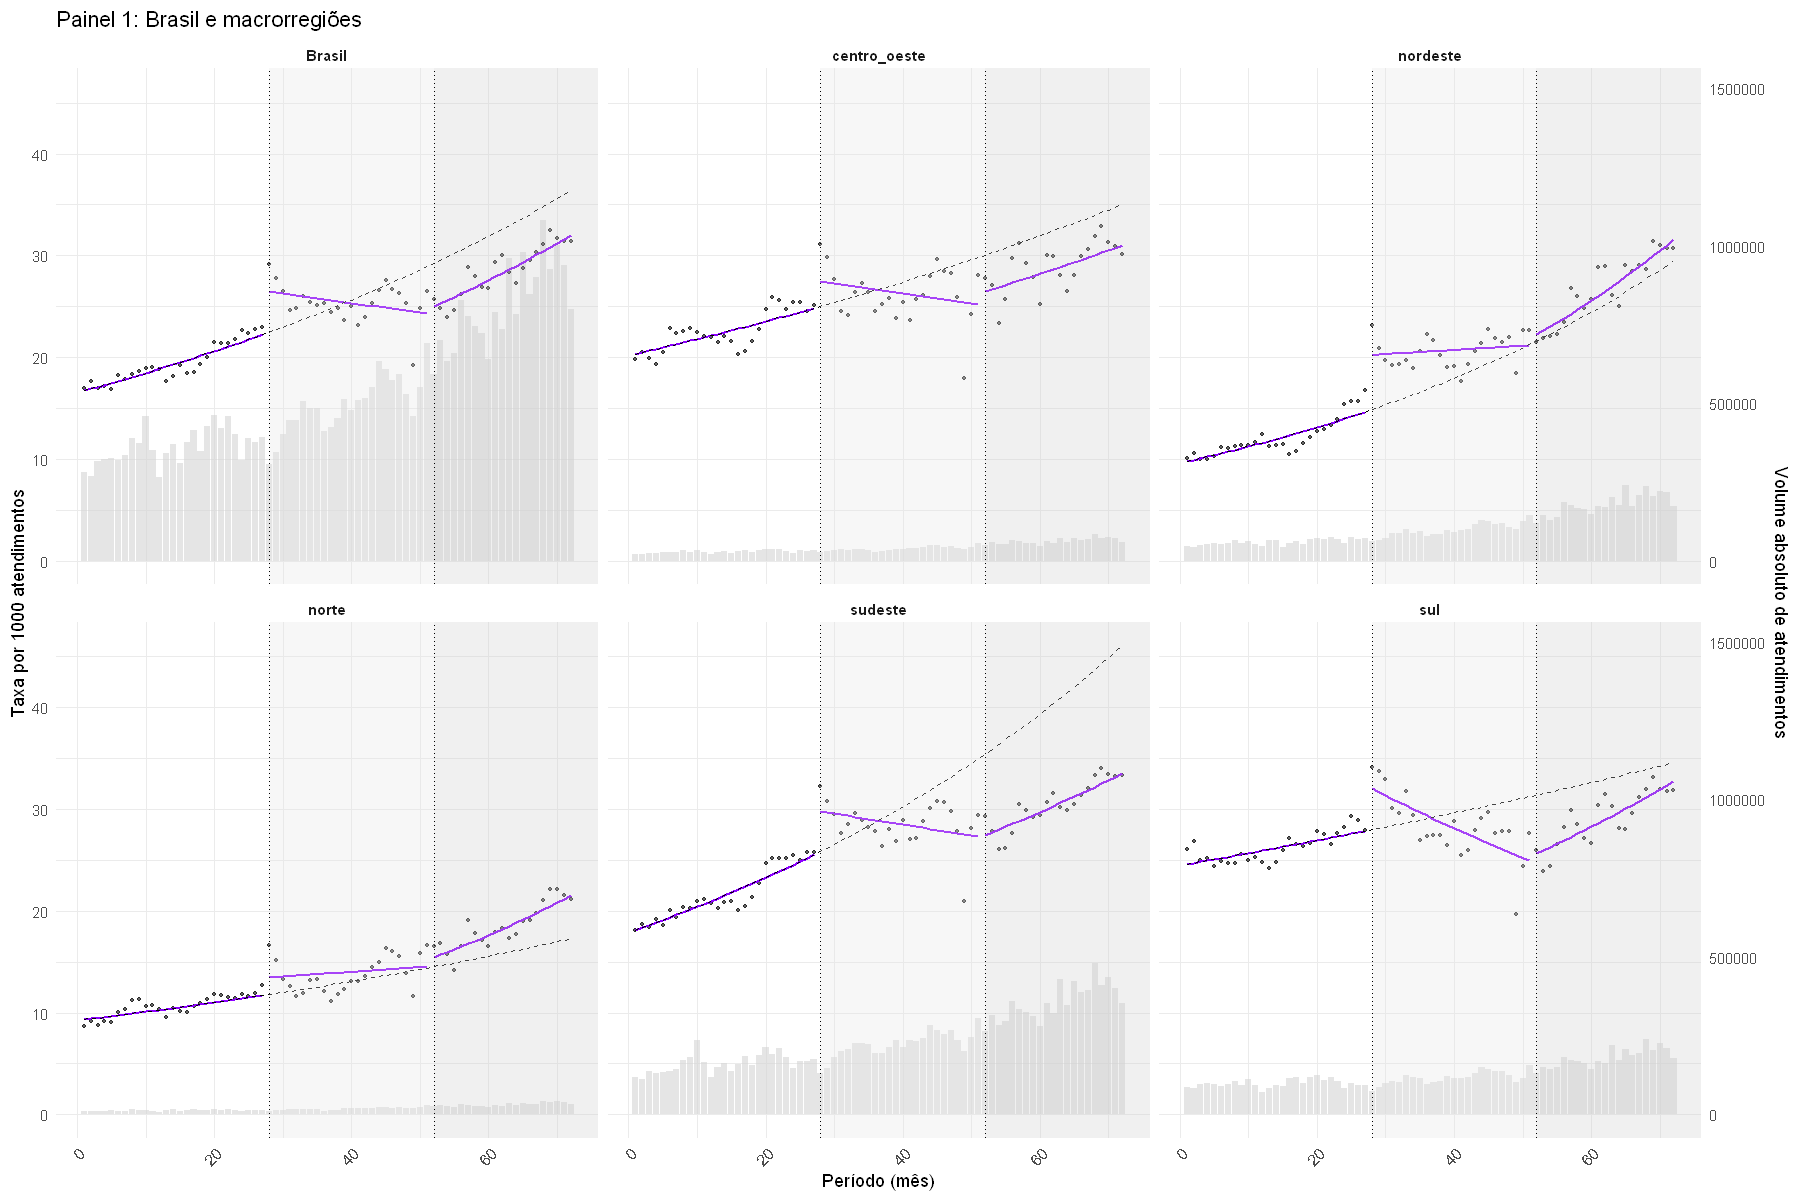

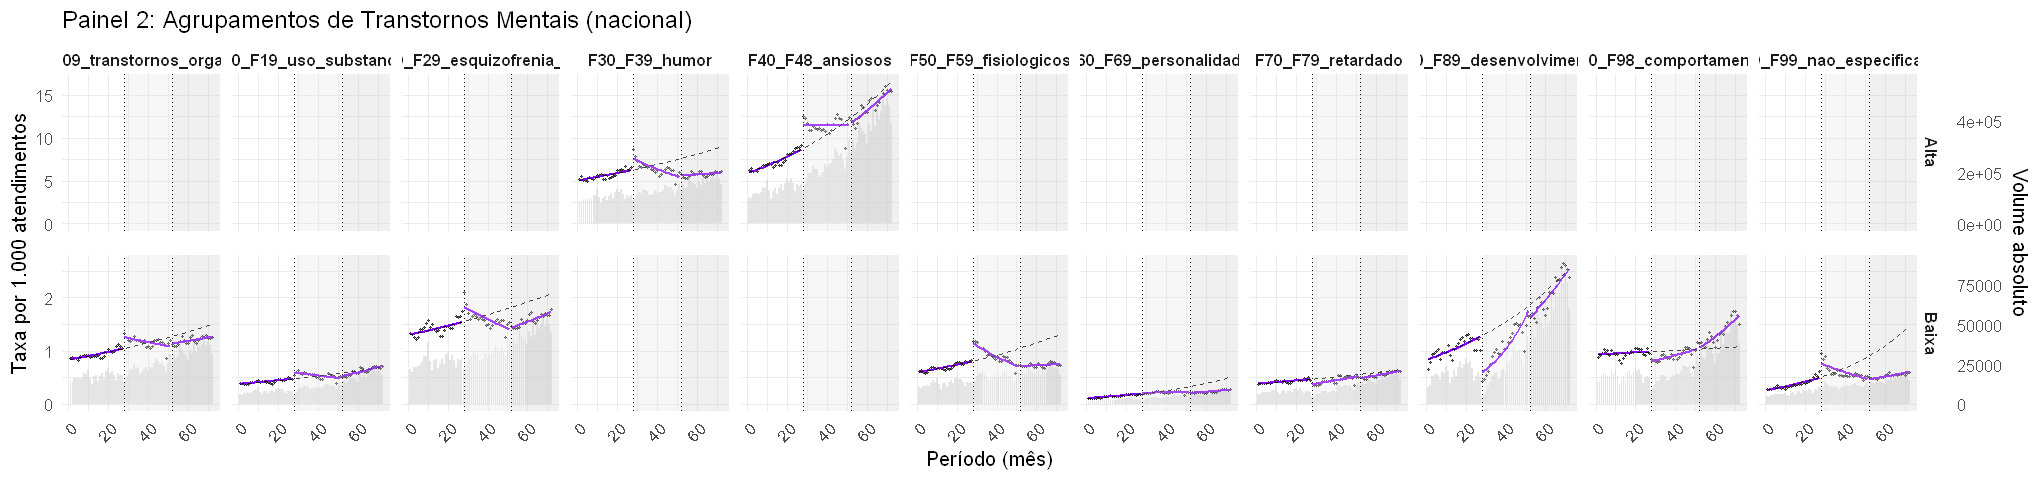

In [24]:
options(repr.plot.width = 15, repr.plot.height = 10)
# plot_its_painel(painel_brasil, titulo = "Brasil", ncol = 1)

plot_its_painel(painel_1, titulo = "Painel 1: Brasil e macrorregiões", ncol = 3, scales = "fixed")

# options(repr.plot.width = 5, repr.plot.height = 20)
# plot_its_painel(painel_2, titulo = "Painel 2: Agrupamentos de Transtornos Mentais (nacional)", ncol = 3)

options(repr.plot.width = 17, repr.plot.height = 4)
plot_its_semi_free(painel_2, titulo = "Painel 2: Agrupamentos de Transtornos Mentais (nacional)")
# plot_its_painel(painel_neuroticos, titulo = "Humor e Ansiedade", scales = "fixed")
